# 인공신경망 모델의 학습

# 학습데이터 불러오기

In [1]:
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math

x_train_path = 'E:/X_train.txt'
y_train_path = 'E:/Y_train.txt'
x_test_path = 'E:/X_test.txt'
y_test_path = 'E:/Y_test.txt'

# 파일을 읽어오기
f = open(x_train_path, 'r')
x_train = f.readlines()
f = open(y_train_path, 'r')
y_train = f.readlines()
f = open(x_test_path, 'r')
x_test = f.readlines()
f = open(y_test_path, 'r')
y_test = f.readlines()

# 읽어온 데이터를 1차원 리스트로 변경 # 2947개의 라인
x_train = [x for x in x_train]
y_train = [y for y in y_train]
x_test = [x for x in x_test]
y_test = [y for y in y_test]


# 리스트에서 마지막에 들어가는 개행문자 제거 rstrip
# 한줄로 되어있는 리스트를 128개로 분할 # 128개의 데이터 split
for i in range(0, len(x_train)):
    x_train[i] = x_train[i].rstrip().split()
    y_train[i] = y_train[i].rstrip().split()
for i in range(0, len(x_test)):
    x_test[i] = x_test[i].rstrip().split()
    y_test[i] = y_test[i].rstrip().split()

# 리스트를 실수형 넘파이로 변경
x_train = np.asarray(x_train, 'float32')
y_train = np.asarray(y_train, 'int').ravel()
x_test = np.asarray(x_test, 'float32')
y_test = np.asarray(y_test, 'int').ravel()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7352, 561)
(7352,)
(2947, 561)
(2947,)


## 원핫인코딩(필요시 사용)

In [2]:
y_train_onehot = np.zeros([7352,6], 'int')
y_test_onehot = np.zeros([2947,6], 'int')

for i in range(0, y_train.size):
    y_train_onehot[i][y_train[i]-1] = 1
for i in range(0, y_test.size):
    y_test_onehot[i][y_test[i]-1] = 1

In [3]:
print(y_train.shape)
print(y_train[0])
print(y_train_onehot.shape)
print(y_train_onehot[0])
print(y_train_onehot.dtype)

(7352,)
5
(7352, 6)
[0 0 0 0 1 0]
int32


## 필요한 라이브러리 불러오기

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

## 데이터 로더

In [5]:
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(7352, 561) float32
(7352,) int32
(2947, 561) float32
(2947,) int32


In [6]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [7]:
def load(batch_size):
    
    transform = None
    train_set = data_loader(x_train, y_train, transform)
    test_set = data_loader(x_test, y_test, transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# 모델, 손실 함수, 최적화 함수 설정

In [13]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(561,250),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Linear(10,6),
        )

    def forward(self,x):
        out = self.layer(x) # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다.
        out = F.softmax(out, dim=1)
        return out

## 하이퍼파라미터

In [14]:
epoch = 100
batch_size = 256
lr = 0.001

In [15]:
train_loader, test_loader = load(batch_size=batch_size)

In [16]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = ANN().to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.L1Loss()


# 최적화함수로는 Adam을 사용합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(),lr=0.0005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=1,patience=1,mode='min')

cuda:0


## 모델의 학습

In [17]:
loss_array = []
for i in range(epoch):
    for j, [image, label] in enumerate(train_loader):
        train_x = image.to(device)
        train_y = label.to(device).long()
        #print(train_x.shape)
        #print(train_y.shape)

        optimizer.zero_grad()
        output = model.forward(train_x)

        #print(output)
        #print(train_y)
        #print(output.dtype)
        #print(train_y.dtype)
        loss = loss_func(output,train_y)
        loss.backward()
        optimizer.step()
    
        loss_array.append(loss)

## 모델 테스트

In [20]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad 해줍니다.
model.eval()
with torch.no_grad():
    for j, [image, label] in enumerate(test_loader):
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y_= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        # 모델 데이터를 CPU로 옮기고 넘파이로 바꾼다음 반올림
        #output = np.around(torch.Tensor.cpu(output).numpy())
        
        _,predicted = torch.max(output,1)
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += y_.size(0)
        
        #y_ = torch.Tensor.cpu(y_).numpy()
        
        
        print(predicted.shape, y_.shape)
        print(predicted.dtype, y_.dtype)
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (predicted == y_).sum()#.float()

    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))

torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([256]) torch.Size([256])
torch.int64 torch.int32
torch.Size([131]) torch.Size([131])
torch.int64 torch.int32
Accuracy of Test Data: 60.841533763148966%


## 결과 출력 /결과 그래프

In [16]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 1000  lr: 0.0001  batch size: 256   ACC: 76.55242619613166%


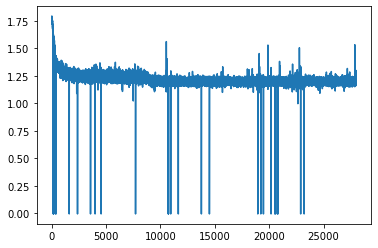

In [17]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()

# 기록

In [91]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 100  lr: 0.001  batch size: 919   ACC: 76.58635900916185%


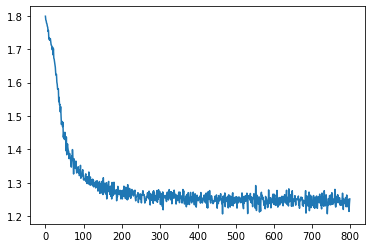

In [92]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()

In [97]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 100  lr: 0.001  batch size: 64   ACC: 74.78791991856124%


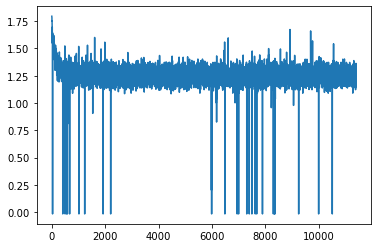

In [98]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()

In [105]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 1000  lr: 0.0005  batch size: 512   ACC: 77.63827621309807%


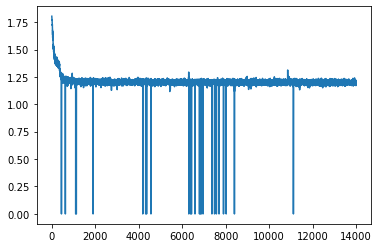

In [106]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()

In [112]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 10000  lr: 0.0001  batch size: 919   ACC: 76.95961995249407%


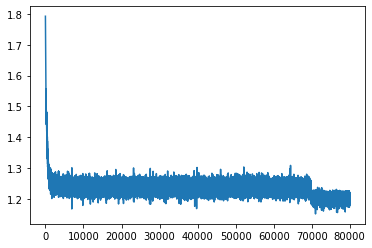

In [113]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()

In [16]:
print(ANN())
print("epoch: {} ".format(epoch),
      "lr: {} ".format(lr),
      "batch size: {}".format(batch_size),
      "  ACC: {}%".format(float(correct) * 100 / total))

ANN(
  (layer): Sequential(
    (0): Linear(in_features=561, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)
epoch: 1000  lr: 0.0001  batch size: 256   ACC: 76.55242619613166%


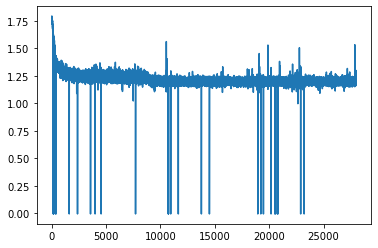

In [17]:
plt.plot(loss_array)
#plt.ylim([0,0.5])
plt.show()